In [1]:
import pandas as pd
import scipy
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import KFold
import numpy as np


In [2]:
df = pd.read_csv('Crime_Data_from_2010_to_Present.csv')

In [4]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,AA,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,IC,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,IC,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",...,IC,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488


In [5]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA ', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [6]:
#drop columns irrelevant to our data analysis
drop_cols = [
    'DR_NO',
    'Date Rptd',
    'AREA ',
    'Rpt Dist No',
    'Part 1-2',
    'Crm Cd',
    'Premis Cd',
    'Premis Desc',
    'Weapon Used Cd',
    'Weapon Desc',
    'Mocodes',
    'Status',
    'Status Desc',
    'Crm Cd 1',
    'Crm Cd 2',
    'Crm Cd 3',
    'Crm Cd 4',
    'Cross Street',
    'LOCATION',
]

df = df.drop(drop_cols, axis=1)
df.columns

Index(['DATE OCC', 'TIME OCC', 'AREA NAME', 'Crm Cd Desc', 'Vict Age',
       'Vict Sex', 'Vict Descent', 'LAT', 'LON'],
      dtype='object')

In [7]:
df.rename(columns={"DATE OCC": "DATE_OCC", "TIME OCC": "TIME_OCC",'AREA NAME':'AREA_NAME','Vict Age':'Vict_Age',
        'Vict Sex':'Vict_Sex', 'Vict Descent': 'Vict_Descent'}, inplace = True)
          
df.columns

Index(['DATE_OCC', 'TIME_OCC', 'AREA_NAME', 'Crm Cd Desc', 'Vict_Age',
       'Vict_Sex', 'Vict_Descent', 'LAT', 'LON'],
      dtype='object')

In [8]:
# clean up date occurred to only contain month/day/year
temp = df['DATE_OCC'].str.split(' ',n = 1, expand = True)
temp2 = temp[0]
df['DATE_OCC'] = temp2

In [9]:
df.head()

,DATE_OCC,TIME_OCC,AREA_NAME,Crm Cd Desc,Vict_Age,Vict_Sex,Vict_Descent,LAT,LON
0,02/20/2010,1350,Newton,VIOLATION OF COURT ORDER,48,M,H,33.9825,-118.2695
1,09/12/2010,45,Pacific,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,33.9599,-118.3962
2,08/09/2010,1515,Newton,OTHER MISCELLANEOUS CRIME,0,M,H,34.0224,-118.2524
3,01/05/2010,150,Hollywood,VIOLATION OF COURT ORDER,47,F,W,34.1016,-118.3295
4,01/02/2010,2100,Central,"RAPE, ATTEMPTED",47,F,H,34.0387,-118.2488


In [10]:
df['Crm Cd Desc'].unique()

array(['VIOLATION OF COURT ORDER',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'OTHER MISCELLANEOUS CRIME', 'RAPE, ATTEMPTED',
       'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
       'BURGLARY FROM VEHICLE',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'BATTERY - SIMPLE ASSAULT', 'ROBBERY', 'BOMB SCARE',
       'CHILD NEGLECT (SEE 300 W.I.C.)',
       'INTIMATE PARTNER - AGGRAVATED ASSAULT',
       'INTIMATE PARTNER - SIMPLE ASSAULT',
       'THEFT PLAIN - PETTY ($950 & UNDER)',
       'CRIMINAL THREATS - NO WEAPON DISPLAYED', 'ATTEMPTED ROBBERY',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'BURGLARY', 'ARSON',
       'RAPE, FORCIBLE', 'BRANDISH WEAPON',
       'THROWING OBJECT AT MOVING VEHICLE',
       'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
       'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
       'SHOTS FIRED AT INHABITED DWELLING',
       'THEFT FROM MOTOR

In [11]:
df.head()

,DATE_OCC,TIME_OCC,AREA_NAME,Crm Cd Desc,Vict_Age,Vict_Sex,Vict_Descent,LAT,LON
0,02/20/2010,1350,Newton,VIOLATION OF COURT ORDER,48,M,H,33.9825,-118.2695
1,09/12/2010,45,Pacific,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,33.9599,-118.3962
2,08/09/2010,1515,Newton,OTHER MISCELLANEOUS CRIME,0,M,H,34.0224,-118.2524
3,01/05/2010,150,Hollywood,VIOLATION OF COURT ORDER,47,F,W,34.1016,-118.3295
4,01/02/2010,2100,Central,"RAPE, ATTEMPTED",47,F,H,34.0387,-118.2488


In [12]:
df['AREA_NAME'].unique()

array(['Newton', 'Pacific', 'Hollywood', 'Central', 'Northeast',
       'Hollenbeck', 'Southwest', 'Southeast', 'Rampart', 'Olympic',
       'Wilshire', '77th Street', 'Harbor', 'West LA', 'Van Nuys',
       'West Valley', 'Topanga', 'N Hollywood', 'Mission', 'Foothill',
       'Devonshire'], dtype=object)

In [13]:
#drop all victimless crime
df.dropna(inplace = True)
df.reset_index(inplace = True)

In [14]:
#non-violent crimes list
non_violent = ['ABORTION/ILLEGAL',
    'BIGAMY',
    'BIKE - ATTEMPTED STOLEN',
    'BIKE - STOLEN',
    'BLOCKING DOOR INDUCTION CENTER',
    'BOAT - STOLEN',
    'BRIBERY',
    'BUNCO, ATTEMPT',
    'BUNCO, GRAND THEFT',
    'BUNCO, PETTY THEFT',
    'BURGLARY',
    'BURGLARY FROM VEHICLE',
    'BURGLARY FROM VEHICLE, ATTEMPTED',
    'BURGLARY, ATTEMPTED',
    'CHILD ABANDONMENT',
    'CHILD ANNOYING (17YRS & UNDER)',
    'CHILD NEGLECT (SEE 300 W.I.C.)',
    'CHILD PORNOGRAPHY',
    'CONSPIRACY',
    'CONTEMPT OF COURT',
    'CONTRIBUTING',
    'COUNTERFEIT',
    'CREDIT CARDS, FRAUD USE ($950 & UNDER',
    'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400',
    'DISHONEST EMPLOYEE - GRAND THEFT',
    'DISHONEST EMPLOYEE - PETTY THEFT',
    'DISHONEST EMPLOYEE ATTEMPTED THEFT',
    'DISRUPT SCHOOL',
    'DISTURBING THE PEACE',
    'DOCUMENT FORGERY / STOLEN FELONY',
    'DOCUMENT WORTHLESS ($200 & UNDER)',
    'DOCUMENT WORTHLESS ($200.01 & OVER)',
    'DRIVING WITHOUT OWNER CONSENT (DWOC)',
    'DRUGS, TO A MINOR',
    'DRUNK ROLL',
    'DRUNK ROLL - ATTEMPT',
    'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
    'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)',
    'EXTORTION',
    'FAILURE TO DISPERSE',
    'FAILURE TO YIELD',
    'FALSE IMPRISONMENT',
    'FALSE POLICE REPORT',
    'FIREARMS RESTRAINING ORDER (FIREARMS RO)',
    'FIREARMS TEMPORARY RESTRAINING ORDER (TEMP FIREARMS RO)',
    'GRAND THEFT / AUTO REPAIR',
    'GRAND THEFT / INSURANCE FRAUD',
    'ILLEGAL DUMPING',
    'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)',
    'INDECENT EXPOSURE',
    'LETTERS, LEWD - TELEPHONE CALLS, LEWD',
    'OTHER MISCELLANEOUS CRIME',
    'PANDERING',
    'PEEPING TOM',
    'PETTY THEFT - AUTO REPAIR',
    'PICKPOCKET',
    'PICKPOCKET, ATTEMPT',
    'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
    'SHOPLIFTING - ATTEMPT',
    'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
    'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
    'THEFT FROM MOTOR VEHICLE - ATTEMPT',
    'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
    'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
    'THEFT OF IDENTITY',
    'THEFT PLAIN - ATTEMPT',
    'THEFT PLAIN - PETTY ($950 & UNDER)',
    'THEFT, COIN MACHINE - ATTEMPT',
    'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)',
    'THEFT, COIN MACHINE - PETTY ($950 & UNDER)',
    'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL',
    'TILL TAP - ATTEMPT',
    'TILL TAP - GRAND THEFT ($950.01 & OVER)',
    'TILL TAP - PETTY ($950 & UNDER)',
    'TRESPASSING',
    'UNAUTHORIZED COMPUTER ACCESS',
    'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
    'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
    'VEHICLE - ATTEMPT STOLEN',
    'VEHICLE - STOLEN',
    'VIOLATION OF COURT ORDER',
    'VIOLATION OF RESTRAINING ORDER',
    'VIOLATION OF TEMPORARY RESTRAINING ORDER',
]

In [15]:
#create new column of violent and non-violent crimes
violent_crime = []

for index in range(len(df['Crm Cd Desc'])):
    if df['Crm Cd Desc'][index] in non_violent:
        violent_crime.append(0)
    else:
        violent_crime.append(1)

In [16]:
df['violent_crime'] = violent_crime
df.head()

,index,DATE_OCC,TIME_OCC,AREA_NAME,Crm Cd Desc,Vict_Age,Vict_Sex,Vict_Descent,LAT,LON,violent_crime
0,0,02/20/2010,1350,Newton,VIOLATION OF COURT ORDER,48,M,H,33.9825,-118.2695,0
1,1,09/12/2010,45,Pacific,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,33.9599,-118.3962,0
2,2,08/09/2010,1515,Newton,OTHER MISCELLANEOUS CRIME,0,M,H,34.0224,-118.2524,0
3,3,01/05/2010,150,Hollywood,VIOLATION OF COURT ORDER,47,F,W,34.1016,-118.3295,0
4,4,01/02/2010,2100,Central,"RAPE, ATTEMPTED",47,F,H,34.0387,-118.2488,1


In [17]:
#get max and min longitude
print('The max and min longitude values are ' + str(np.max(df['LON'])) + ' & ' + str(np.min(df['LON'])))
#get max and min latitude
print('The max and min latitude values are ' + str(np.max(df['LAT'])) + ' & ' + str(np.min(df['LAT'])))
#plot LAT v LON to visualize where crimes occur in LA


The max and min longitude values are 0.0 & -118.8279
The max and min latitude values are 34.7907 & 0.0


In [18]:
#drop all rows where lat or longitude = 0
df = df[df['LAT'] != 0]

In [19]:
#get max and min longitude
print('The max and min longitude values are ' + str(np.max(df['LON'])) + ' & ' + str(np.min(df['LON'])))
#get max and min latitude
print('The max and min latitude values are ' + str(np.max(df['LAT'])) + ' & ' + str(np.min(df['LAT'])))
#plot LAT v LON to visualize where crimes occur in LA

The max and min longitude values are -117.6596 & -118.8279
The max and min latitude values are 34.7907 & 33.3427


In [21]:
df['Vict_Age'].unique()

array([48,  0, 47, 23, 46, 51, 30, 55, 38, 40, 24, 29, 41, 11, 50, 18, 37,
       28, 25, 31, 36, 61, 27, 32, 45, 22, 35, 44, 20, 33, 26, 52, 62, 39,
       54, 76, 16, 21, 57, 34, 65,  5, 49, 58, 56, 59, 42,  9, 60, 92, 43,
       19, 15, 17, 63, 83,  6, 13, 12,  7, 53, 10, 99, 74, 84, 68, 82, 66,
       64, 14, 69, 70, 71, 73, 78, 67, 80, 81, 72, 86, 79, 75, 77,  2,  4,
        8, 93, 85,  3, 91, 89, 87, 90, 88, 96, 95, 97, 98, 94, -1, -2, -3,
       -4, -6, -5, -7, -9, -8], dtype=int64)

In [22]:
df['Vict_Sex'].unique()

array(['M', 'F', 'X', 'H', '-', 'N'], dtype=object)

In [23]:
# simplify data to binary M/F - 1/0
df_analyze = df[df['Vict_Sex'] == 'M']
df_analyze = df_analyze.append(df[df['Vict_Sex'] == 'F'])
df_analyze['Vict_Sex'].unique()

array(['M', 'F'], dtype=object)

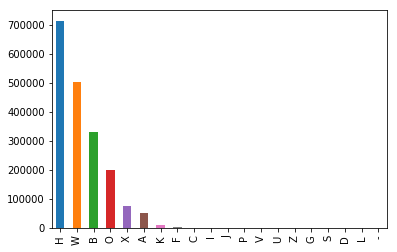

In [24]:
df['Vict_Descent'].value_counts().plot(kind = 'bar')

f1 = plt.gcf()

In [93]:
df_analyze.reset_index(inplace = True)
df_analyze.head()

ValueError: cannot insert level_0, already exists

In [26]:
#remove X = unknown and ' = not listed
convert_other_lst = ['A','K','F','C','I','J','P','V','U','Z','G','S','D','L']
descent_lst = []
for index in range(len(df_analyze['Vict_Descent'])):
    if df_analyze['Vict_Descent'][index] in convert_other_lst:
        descent_lst.append('O')
    else:
        descent_lst.append(df_analyze['Vict_Descent'][index])


In [27]:
df_analyze['Vict_Descent'] = descent_lst
df_analyze = df_analyze[df_analyze['Vict_Descent'] != 'X']
df_analyze = df_analyze[df_analyze['Vict_Descent'] != '-']

In [89]:
#convert TIME_OCC to morning afternoon night
#day = 6am - 6pm
#night = 6pm - 6am

time_lst = []
for time in  df_analyze['TIME_OCC']:
    if time >= 600 and time < 1800:
        time_lst.append('Day')
    else:
        time_lst.append('Night')


In [90]:
len(df_analyze)
len(time_lst)

1704472

In [91]:
df_analyze['TIME_OCC'] = time_lst

In [92]:
#create new dataframe for making predictions without data that we cannot analyze
#remove rows with Age <= 0
df_analyze = df_analyze[df_analyze['Vict_Age'] > 0]
df_analyze['Vict_Age'].unique()

array([48, 23, 46, 51, 30, 55, 40, 47, 41, 11, 50, 37, 28, 31, 36, 27, 24,
       35, 44, 20, 33, 26, 62, 54, 76, 22, 34, 65,  5, 49, 57, 58, 56, 45,
       59, 61, 32, 18, 39,  9, 60, 21, 38, 43, 15, 42, 52, 63, 17,  6, 25,
       19, 29,  7, 53, 99, 16, 82, 64, 69, 70, 71, 67, 80, 92, 81, 72, 14,
       74, 12, 73, 66, 79, 68, 77,  2, 84, 75, 13, 78, 85,  4,  8, 10, 86,
        3, 91, 87, 93, 83, 89, 90, 88, 95, 97, 94, 96, 98], dtype=int64)

In [29]:
years = []
for date in df['DATE_OCC']:
    data = date.split('/')
    years.append(int(data[2]))

In [30]:
df['DATE_OCC'].head()
df['Year'] = years

In [31]:
df['Year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int64)

In [ ]:
# split df into 2010-2012, 2013-2015, 2016-2018

df_10_12 = df[(df['Year'] == 2010)]
df_10_12 = df_10_12.append(df[(df['Year'] == 2011)])
df_10_12 = df_10_12.append(df[(df['Year'] == 2012)])

df_13_15 = df[(df['Year'] == 2013)]
df_13_15 = df_13_15.append(df[(df['Year'] == 2014)])
df_13_15 = df_13_15.append(df[(df['Year'] == 2015)])


df_16_18 = df[(df['Year'] == 2016)]
df_16_18 = df_16_18.append(df[(df['Year'] == 2017)])
df_16_18 = df_16_18.append(df[(df['Year'] == 2018)])
df_16_18 = df_16_18.append(df[(df['Year'] == 2019)])


#df_10_12 = df.loc
#plot lat v lon in different colors to visualize where crime is happening in LA
#

In [ ]:
print(len(df_10_12))
print(len(df_13_15))
print(len(df_16_18))

In [32]:
#get max and min longitude
print('The max and min longitude values are ' + str(np.max(df_analyze['LON'])) + ' & ' + str(np.min(df_analyze['LON'])))
#get max and min latitude
print('The max and min latitude values are ' + str(np.max(df_analyze['LAT'])) + ' & ' + str(np.min(df_analyze['LAT'])))
#plot LAT v LON to visualize where crimes occur in LA

The max and min longitude values are -117.6596 & -118.8279
The max and min latitude values are 34.7907 & 33.3427


In [ ]:
#plot of all crimes lat v lon
plt.scatter(df['LON'],df['LAT'])
plt.xlim([-117.6596,-118.8279])
plt.ylim([33.3427, 34.7907])
plt.ylabel('Latitude')
plt.xlabel('Longitude')

In [ ]:
plt.scatter(df_analyze['LON'],df_analyze['LAT'])
plt.xlim([-118.465381,-118.138795])
plt.ylim([34.016907, 34.105999])
plt.ylabel('Latitude')
plt.xlabel('Longitude')

In [33]:
#make separate data frames to hold only mature and immature gene expression sets
data_v = df_analyze[df_analyze['violent_crime'] == 1]
#data_mature.head()
data_nv = df_analyze[df_analyze['violent_crime'] == 0]
#data_immature.head()

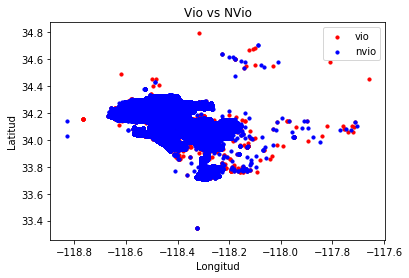

In [34]:
#plot mature data as red
plt.scatter(data_v['LON'], data_v['LAT'], c = 'red',s = 10, label = 'vio')
# plot immature data as blue
plt.scatter(data_nv['LON'], data_nv['LAT'], c = 'blue',s = 10, label = 'nvio')
#create labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Violent vs Non-Violent')
plt.legend(loc = 'best')

In [ ]:
plt.scatter(data_nv['LON'], data_nv['LAT'], c = 'blue',s = 10, label = 'nvio')
#create labels
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Vio vs NVio')
plt.legend(loc = 'best')

In [ ]:
np.argmin(df['LON'])

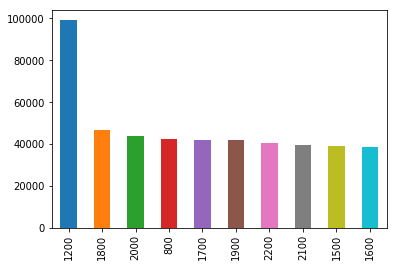

In [35]:
df_analyze['TIME_OCC'].value_counts()[:10].plot(kind = 'bar')

f0 = plt.gcf()

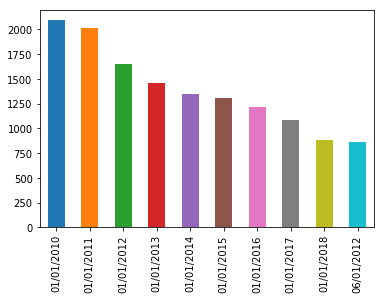

In [36]:
df_analyze['DATE_OCC'].value_counts()[:10].plot(kind = 'bar')

f1 = plt.gcf()

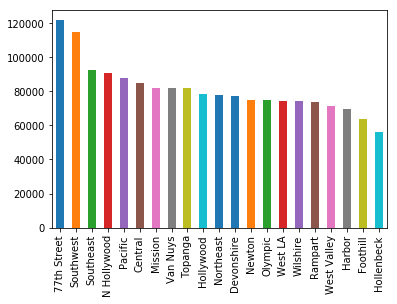

In [37]:
df_analyze['AREA_NAME'].value_counts().plot(kind = 'bar')

f2 = plt.gcf()

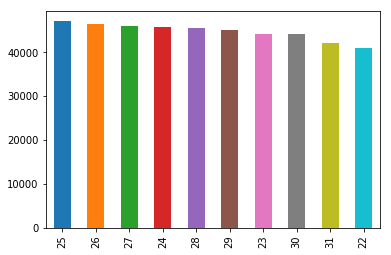

In [39]:
df_analyze['Vict_Age'].value_counts()[:10].plot(kind = 'bar')

f3 = plt.gcf()

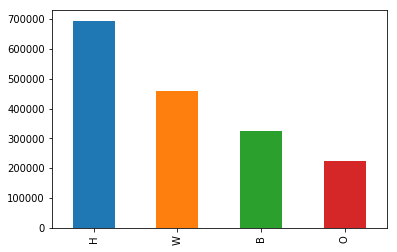

In [40]:
df_analyze['Vict_Descent'].value_counts().plot(kind = 'bar')

f4 = plt.gcf()

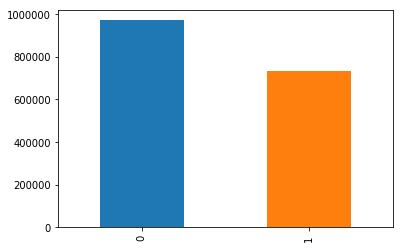

In [41]:
df_analyze['violent_crime'].value_counts().plot(kind = 'bar')

f5 = plt.gcf()

In [42]:
df['Vict_Descent'].unique()

array(['H', 'W', 'B', 'A', 'O', 'X', 'K', 'I', 'J', 'F', 'C', 'P', 'V',
       'U', 'G', 'D', 'S', 'Z', 'L', '-'], dtype=object)

What can we drop? (eg '0' ages, unknown descent) - new dataframes?, X,H,N genders
multi logistic regression
how to do knn
    formula = 'Vict Sex ~ TIME OCC + LAT + LON'
    age, descent too
    

In [ ]:
#plot geographical data, violent and non violent separated by color

#sklearn multiple logistic regression

    # pay equal attention class_weight = balanced
    

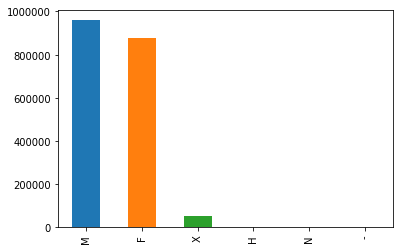

In [43]:
df['Vict_Sex'].value_counts().plot(kind = 'bar')

f4 = plt.gcf()
#plot which crimes affect which gender the most
#gender and violent v nonviolent crimes

In [ ]:
df['Crm Cd Desc'].value_counts()[:20].plot(kind = 'bar')

f4 = plt.gcf()

### Perform logistic regression to determine a relationship between time/location and the type of crime committed 
- predictors = latitude, longitude, time occurred
- response = violent crime (1)/non violent crime (0)


Text(0.5, 1.0, 'Time prediction')

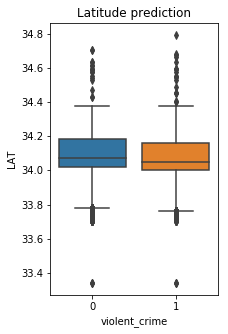

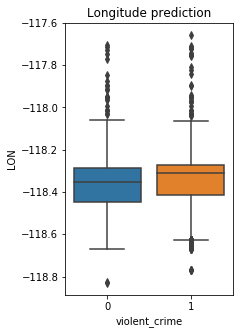

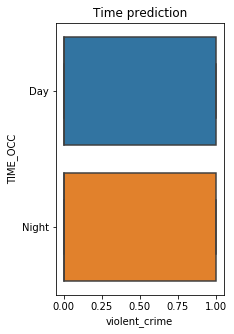

In [122]:
fig, ax = plt.subplots(figsize = (3,5))
lat_box = sns.boxplot(x = 'violent_crime', y = 'LAT', data = df_analyze, ax = ax)
lat_box.set_title('Latitude prediction')

fig, ax = plt.subplots(figsize = (3,5))
long_box = sns.boxplot(x = 'violent_crime', y = 'LON', data = df_analyze, ax = ax)
long_box.set_title('Longitude prediction')

fig, ax = plt.subplots(figsize = (3,5))
time_box = sns.boxplot(x = 'violent_crime', y = 'TIME_OCC', data = df_analyze, ax = ax)
time_box.set_title('Time prediction')

In [ ]:
#plots for violent crime enacted toward Vict_age, Vict_Sex, Vict_descent

In [96]:
pred_formula = 'violent_crime ~ 1  + TIME_OCC + AREA_NAME + Vict_Age + Vict_Sex + Vict_Descent + LAT + LON'
mult_mdl = smf.logit(formula = pred_formula, data = df_analyze)
results = mult_mdl.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.645483
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          violent_crime   No. Observations:              1704472
Model:                          Logit   Df Residuals:                  1704443
Method:                           MLE   Df Model:                           28
Date:                Tue, 03 Dec 2019   Pseudo R-squ.:                 0.05559
Time:                        18:29:13   Log-Likelihood:            -1.1002e+06
converged:                       True   LL-Null:                   -1.1650e+06
                                        LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   40.7571      8.397      4.854      0.000      24.300      57.214
TIME_OCC[T.Night]            0.1972      0.003     60.932      0.000       0.191       0.204
AREA_NAME[T.Central]         0.1795      0.011     15.845      0.000       0.157       0.202
AREA_NAME[T.Devonshire]     -0.3471      0.029    -12.018      0.000      -0.404      -0.290
AREA_NAME[T.Foothill]       -0.1454      0.025     -5.877      0.000      -0.194      -0.097
AREA_NAME[T.Harbor]         -0.4250      0.020    -21.539      0.000      -0.464      -0.386
AREA_NAME[T.Hollenbeck]     -0.0338      0.014     -2.417      0.016      -0.061      -0.006
AREA_NAME[T.Hollywood]       0.0059      0.014      0.425      0.671      -0.021       0.033
AREA_NAME[T.Mission]        -0.1368      0.026     -5.203      0.000      -0.188      -0.085
AREA_NAME[T.N Hollywood]    -0.3262      0.019    -17.017      0.000      -0.364      -0.289
AREA_NAME[T.Newton]          0.1522      0.010     14.919      0.000       0.132       0.172
AREA_NAME[T.Northeast]      -0.3188      0.015    -21.368      0.000      -0.348      -0.290
AREA_NAME[T.Olympic]         0.1023      0.012      8.684      0.000       0.079       0.125
AREA_NAME[T.Pacific]        -0.3743      0.013    -28.871      0.000      -0.400      -0.349
AREA_NAME[T.Rampart]         0.1371      0.012     11.384      0.000       0.113       0.161
AREA_NAME[T.Southeast]       0.0134      0.010      1.384      0.166      -0.006       0.032
AREA_NAME[T.Southwest]      -0.1972      0.009    -21.553      0.000      -0.215      -0.179
AREA_NAME[T.Topanga]        -0.2804      0.028     -9.897      0.000      -0.336      -0.225
AREA_NAME[T.Van Nuys]       -0.2653      0.021    -12.501      0.000      -0.307      -0.224
AREA_NAME[T.West LA]        -0.4207      0.015    -27.549      0.000      -0.451      -0.391
AREA_NAME[T.West Valley]    -0.2080      0.025     -8.452      0.000      -0.256      -0.160
AREA_NAME[T.Wilshire]       -0.3757      0.012    -30.116      0.000      -0.400      -0.351
Vict_Sex[T.M]               -0.1506      0.003    -46.504      0.000      -0.157      -0.144
Vict_Descent[T.H]           -0.1658      0.005    -35.313      0.000      -0.175      -0.157
Vict_Descent[T.O]           -0.7301      0.006   -116.605      0.000      -0.742      -0.718
Vict_Descent[T.W]           -0.6195      0.005   -114.708      0.000      -0.630      -0.609
Vict_Age                    -0.0201      0.000   -187.227      0.000      -0.020      -0.020
LAT                         -0.6967      0.081     -8.623      0.000      -0.855      -0.538
LON                          0.1358      0.068      2.010      0.044       0.003       0.268
============================================================================================
"""

In [46]:
#append predicted violent crimes to model with threshold = 0.3
#In this dataset, there is a larger amount of non-violent crimes committed than violent
# we want to focus on correctly classifying violent crimes committed, 
# at the expense of misclassifying non-violent crimes
# better safe than sorry 
thresh = 0.3
df_analyze['pred_violent'] = (results.predict() > thresh).astype(int)


In [47]:
#create confusion matrix with predicted violent crimes and actual violent crimes
violent_conf_mat = metrics.confusion_matrix(df_analyze['violent_crime'],df_analyze['pred_violent'])
df_cm = pd.DataFrame(violent_conf_mat, index = ['true_nonviolent','true_violent'], columns = ['predicted_nonviolent','predicted_violent'])

df_cm

,predicted_nonviolent,predicted_violent
true_nonviolent,240848,729698
true_violent,84972,648954


In [48]:
def sensitivity(conf_mat):
    return conf_mat[1,1]/np.sum(conf_mat[1,:])
def specificity(conf_mat):
    return conf_mat[0,0]/np.sum(conf_mat[0,:])

In [49]:
sensitivity(violent_conf_mat)

0.8842226600501958

In [50]:
specificity(violent_conf_mat)

0.24815722284157576

Text(0, 0.5, 'False Positive Rate')

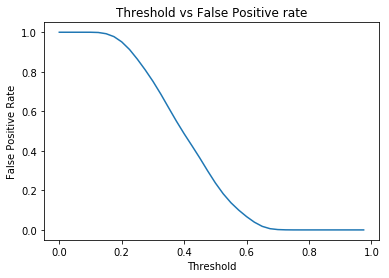

In [68]:
#threshold v FP rate

# initialize empty matrix to fill with false positive values
false_pos = [] 

threshold = np.arange(0,1,.025)
# for each threshold from 0-1
for i in threshold:
    df_analyze['pred_violent_temp'] = (results.predict() > i).astype(int) # use current threshold to create predictions
    
    #make confusion matrix between mature and prediction
    temp_confusion = metrics.confusion_matrix(df_analyze['violent_crime'], df_analyze['pred_violent_temp'])
    
    #calc false positive rate
    temp_FP = temp_confusion[0,1]/np.sum(temp_confusion[:1])
    false_pos.append(temp_FP)


    

plt.plot(threshold,false_pos)
plt.title('Threshold vs False Positive rate')
plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')

In [75]:
#precision TP / P* = True pos/ (true pos + false pos)
#recall  TP / P = true pos/ all pos
#F1 Score = 2* Precision*Recall/(Precision + Recall)
precision = []
recall = []
f_score = []
acc = []

for i in threshold:
    df_analyze['pred_violent_temp'] = (results.predict() > i).astype(int)
    temp_confusion = metrics.confusion_matrix(df_analyze['violent_crime'], df_analyze['pred_violent_temp'])
    
    temp_acc = metrics.accuracy_score(df_analyze['violent_crime'],df_analyze['pred_violent_temp'])
    temp_precision = temp_confusion[1,1] / (temp_confusion[1,1] + temp_confusion[0,1])
    temp_recall = temp_confusion[1,1] / (np.sum(temp_confusion[1:]))
    temp_fscore = (2 * temp_precision * temp_recall) / (temp_precision + temp_recall)
    
    #append
    precision.append(temp_precision)
    recall.append(temp_recall)
    f_score.append(temp_fscore)
    acc.append(temp_acc)


C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  


Text(0, 0.5, 'Magnitude')

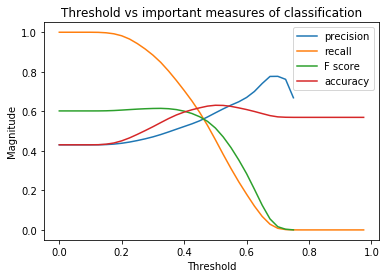

In [76]:
plt.plot(threshold, precision, label = 'precision')
plt.plot(threshold, recall, label = 'recall')
plt.plot(threshold, f_score, label = 'F score')
plt.plot(threshold, acc, label = 'accuracy')
plt.legend()
plt.xlabel('Threshold')
plt.title('Threshold vs important measures of classification')
plt.ylabel('Magnitude')


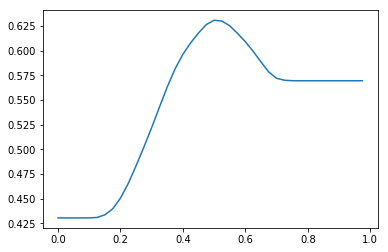

In [74]:
plt.plot(threshold,acc,label = 'accuracy')

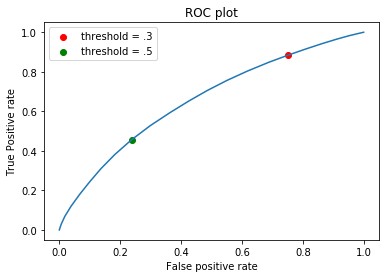

In [54]:
# ROC TP rate v FP rate for all threshold x = FP y = TP

#recall = TP rate, false_pos = FP rate
plt.plot(false_pos,recall)
plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC plot')

#symbol to show point on ROC that corresponds to threshold = 0.5
ROC_df = pd.DataFrame()
ROC_df['Threshold'] = threshold
ROC_df['TP Rate'] = recall
ROC_df['FP Rate'] = false_pos

plt.scatter(.751843,.884223, color = 'r', label = 'threshold = .3') 
plt.scatter(.237601,.456368, c = 'g',label = 'threshold = .5')
plt.legend()
#second symbol to show point at threshold = .2

In [ ]:
ROC_df

In [55]:
def accuracy(conf_mat):
    return (conf_mat[0, 0] + conf_mat[1, 1])/np.sum(np.ravel(conf_mat))
def error_rate(conf_mat):
    return 1 - accuracy(conf_mat) 

In [56]:
for thresh in threshold:
    predict -> metrics.accuracy_score()

SyntaxError: invalid syntax (<ipython-input-56-78e36e573ebe>, line 2)

In [57]:
# estimate test error, div all observations into k = 2 folds (randomize)
#for loop selects one fold at a time to be held out
k = 2
threshold = 0.3
kf = KFold(n_splits=k, shuffle=True)
train_errs = []
test_errs = []

for train_index, test_index in kf.split(df_analyze):
    df_train = df_analyze.iloc[train_index, :]
    df_test = df_analyze.iloc[test_index, :]
    
    # logistic regression
    res = smf.logit(pred_formula, data=df_train).fit(disp=0)
    # total error rate 
    train_pred_temp = (res.predict(df_train) > threshold).astype(int)
    train_conf_mat = metrics.confusion_matrix(df_train['violent_crime'], train_pred_temp)
    train_err = error_rate(train_conf_mat)
    train_errs.append(train_err)
    
    test_pred_temp = (res.predict(df_test) > threshold).astype(int)
    test_conf_mat = metrics.confusion_matrix(df_test['violent_crime'], test_pred_temp)
    test_err = error_rate(test_conf_mat)
    test_errs.append(test_err)
    


In [58]:
res_table = pd.DataFrame()
res_table['training error rate'] = train_errs
res_table['test error rate'] = test_errs
res_table

,training error rate,test error rate
0,0.478011,0.478506
1,0.477722,0.477499


In [59]:
#mean training error 
print(res_table.mean())
#standard error of the mean
print(res_table.sem())

training error rate    0.477866
test error rate        0.478003
dtype: float64
training error rate    0.000144
test error rate        0.000503
dtype: float64


In [60]:
# estimate test error, div all observations into k = 2 folds (randomize)
#for loop selects one fold at a time to be held out
k = 4
threshold = 0.3
kf = KFold(n_splits=k, shuffle=True)
train_errs_4 = []
test_errs_4 = []

for train_index, test_index in kf.split(df_analyze):
    df_train = df_analyze.iloc[train_index, :]
    df_test = df_analyze.iloc[test_index, :]
    
    # logistic regression
    res = smf.logit(pred_formula, data=df_train).fit(disp=0)
    # total error rate 
    train_pred_temp = (res.predict(df_train) > threshold).astype(int)
    train_conf_mat = metrics.confusion_matrix(df_train['violent_crime'], train_pred_temp)
    train_err = error_rate(train_conf_mat)
    train_errs_4.append(train_err)
    
    test_pred_temp = (res.predict(df_test) > threshold).astype(int)
    test_conf_mat = metrics.confusion_matrix(df_test['violent_crime'], test_pred_temp)
    test_err = error_rate(test_conf_mat)
    test_errs_4.append(test_err)
    


In [61]:
res_table4 = pd.DataFrame()
res_table4['training error rate'] = train_errs_4
res_table4['test error rate'] = test_errs_4
res_table4

,training error rate,test error rate
0,0.478050,0.476722
1,0.477482,0.479048
2,0.478098,0.477800
3,0.478209,0.478457


In [62]:
#mean training error 
print(res_table4.mean())
#standard error of the mean
print(res_table4.sem())

training error rate    0.477960
test error rate        0.478007
dtype: float64
training error rate    0.000163
test error rate        0.000498
dtype: float64


In [63]:
# estimate test error, div all observations into k = 2 folds (randomize)
#for loop selects one fold at a time to be held out
k = 5
threshold = 0.3
kf = KFold(n_splits=k, shuffle=True)
train_errs_5 = []
test_errs_5 = []

for train_index, test_index in kf.split(df_analyze):
    df_train = df_analyze.iloc[train_index, :]
    df_test = df_analyze.iloc[test_index, :]
    
    # logistic regression
    res = smf.logit(pred_formula, data=df_train).fit(disp=0)
    # total error rate 
    train_pred_temp = (res.predict(df_train) > threshold).astype(int)
    train_conf_mat = metrics.confusion_matrix(df_train['violent_crime'], train_pred_temp)
    train_err = error_rate(train_conf_mat)
    train_errs_5.append(train_err)
    
    test_pred_temp = (res.predict(df_test) > threshold).astype(int)
    test_conf_mat = metrics.confusion_matrix(df_test['violent_crime'], test_pred_temp)
    test_err = error_rate(test_conf_mat)
    test_errs_5.append(test_err)
    


In [64]:
res_table5 = pd.DataFrame()
res_table5['training error rate'] = train_errs_5
res_table5['test error rate'] = test_errs_5
res_table5

,training error rate,test error rate
0,0.477966,0.477640
1,0.478227,0.478335
2,0.478087,0.477462
3,0.477971,0.479076
4,0.477715,0.477489


In [65]:
#mean training error 
print(res_table5.mean())
#standard error of the mean
print(res_table5.sem())

training error rate    0.477993
test error rate        0.478000
dtype: float64
training error rate    0.000084
test error rate        0.000312
dtype: float64


### Perform K-Fold(2,5,10) using samples of the dataframe (fraction = 0.1, 0.25, 0.5) 

In [102]:
sample_10 = df_analyze.sample(frac = 0.10)
sample_25 = df_analyze.sample(frac = 0.25)
sample_50 = df_analyze.sample(frac = 0.50)


In [110]:
m_df_analyze = df_analyze[df_analyze['Vict_Sex'] == 'M']
f_df_analyze = df_analyze[df_analyze['Vict_Sex'] == 'F']

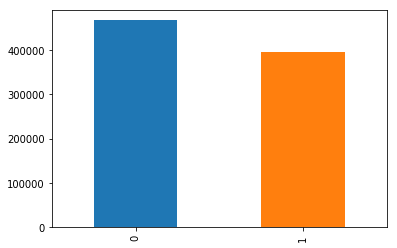

In [112]:

f_df_analyze['violent_crime'].value_counts().plot(kind = 'bar')

In [120]:
m_df_analyze.groupby('violent_crime').count()

,level_0,index,DATE_OCC,TIME_OCC,AREA_NAME,Crm Cd Desc,Vict_Age,Vict_Sex,Vict_Descent,LAT,LON,pred_violent,pred_violent_temp
violent_crime,,,,,,,,,,,,,
0,503341,503341,503341,503341,503341,503341,503341,503341,503341,503341,503341,503341,503341
1,339242,339242,339242,339242,339242,339242,339242,339242,339242,339242,339242,339242,339242


In [121]:
f_df_analyze.groupby('violent_crime').count()

,level_0,index,DATE_OCC,TIME_OCC,AREA_NAME,Crm Cd Desc,Vict_Age,Vict_Sex,Vict_Descent,LAT,LON,pred_violent,pred_violent_temp
violent_crime,,,,,,,,,,,,,
0,467205,467205,467205,467205,467205,467205,467205,467205,467205,467205,467205,467205,467205
1,394684,394684,394684,394684,394684,394684,394684,394684,394684,394684,394684,394684,394684


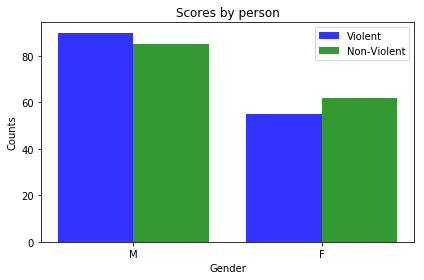

In [156]:
n_groups = 2

counts_violent = (90, 55)
counts_nonvio = (85, 62)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8

rects1 = plt.bar(index, counts_violent, bar_width,
alpha=opacity,
color='b',
label='Violent')

rects2 = plt.bar(index + bar_width, counts_nonvio, bar_width,
alpha=opacity,
color='g',
label='Non-Violent')

plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Scores by person')
plt.xticks(index + 0.5*bar_width, ('M', 'F'))
plt.legend()

plt.tight_layout()
plt.show()